In [1]:
import kaleido as kd
import nbformat as nb
import numpy as np
import pandas as pd
import datetime
from datetime import date, timedelta
from time import sleep
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as pyo
from plotly.graph_objs import *
from tqdm.notebook import trange, tqdm
%matplotlib inline

In [2]:
from bs4 import BeautifulSoup


In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By


In [4]:
chromedriver_path = os.getcwd() + '/Driver/chromedriver'
browser = webdriver.Chrome(service=Service(ChromeDriverManager().install()))


[WDM] - Downloading: 100%|██████████| 6.80M/6.80M [00:00<00:00, 20.6MB/s]


In [5]:
travel_date = "2023-05-20"
origin = 'ATL'
destination = 'LAX'
scope = 2

In [6]:

start = (datetime.datetime.strptime(travel_date,"%Y-%m-%d")) - timedelta(days=7)
t = trange(scope)
for n in t:
    start_date = str(start + timedelta(days=n)).split()[0]
    t.set_description('Checking Dates: ' + start_date)
    end_date = str((start + timedelta(days=n)) + timedelta(days=14)).split()[0]
    for location in destination:
        h=[]
        airl=[]
        airp=[]
        p=[]
        full_list = {}
        sats = "https://www.kayak.com/flights/"+origin+"-"+destination+"/"+str(start_date)+"/"+str(end_date)+"?sort=bestflight_a&fs=stops=0"
        browser.get(sats)
        sleep(5)
        #changed browser.find_elements_by_css_selector to browser.findElements()
        hours = browser.find_elements(By.CSS_SELECTOR, '.gws-flights-results__times')
        
        for hour in hours:
            h.append(hour.text)
        full_list['Flight'] = h
        airlines = browser.find_elements(By.XPATH, './/span[@class = "gws-flights__ellipsize"]')
        for airline in airlines:
            airl.append(airline.text)
        full_list['Airline'] = airl

        #changed browser.find_elements_by_css_selector to browser.findElement()
        airports = browser.find_elements(By.CSS_SELECTOR, '.gws-flights-results__airports') 
        


        for airport in airports:
            airp.append(airport.text)
        full_list['Airport'] = airp
        #changed browser.find_elements_by_css_selector to browser.findElement()
        prices = browser.find_elements(By.CSS_SELECTOR, '.gws-flights-results__price')
        
        for price in prices:
            p.append(price.text)
        p = list(filter(None, p))
        full_list['Price'] = p
        temp = pd.DataFrame(full_list)
        temp['Destination'] = location
        temp['Departure'] = start_date
        temp['Return'] = end_date
        
        

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
print(full_list)

{'Flight': [], 'Airline': [], 'Airport': [], 'Price': []}


In [7]:
df[(df['Departure']=='2023-05-24') & (df['Destination']=='LAX')]

NameError: name 'df' is not defined

In [51]:
cheapest = df.groupby(['Departure','Destination'])['Price'].min().reset_index()
cheapest.sort_values(by=['Departure','Price'], inplace=True)
cheapest['Price'] = cheapest['Price'].replace('$', '')
cheapest['Price'] = cheapest['Price'].replace(',', '')
cheapest['Price'] = cheapest['Price'].apply(pd.to_numeric)
cheapest['Departure'] = pd.to_datetime(cheapest['Departure'])

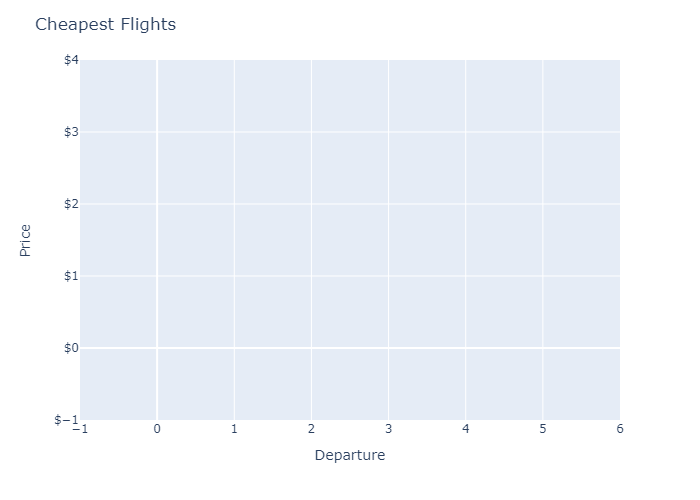

In [54]:
fig = px.line(cheapest, x='Departure', y='Price', color='Destination')
fig.update_yaxes(tickprefix="$", tickformat=",")
fig.update_xaxes(tickformat="%d %b (%a)")
fig.update_layout(title_text="Cheapest Flights")
fig.show('png')

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font fam

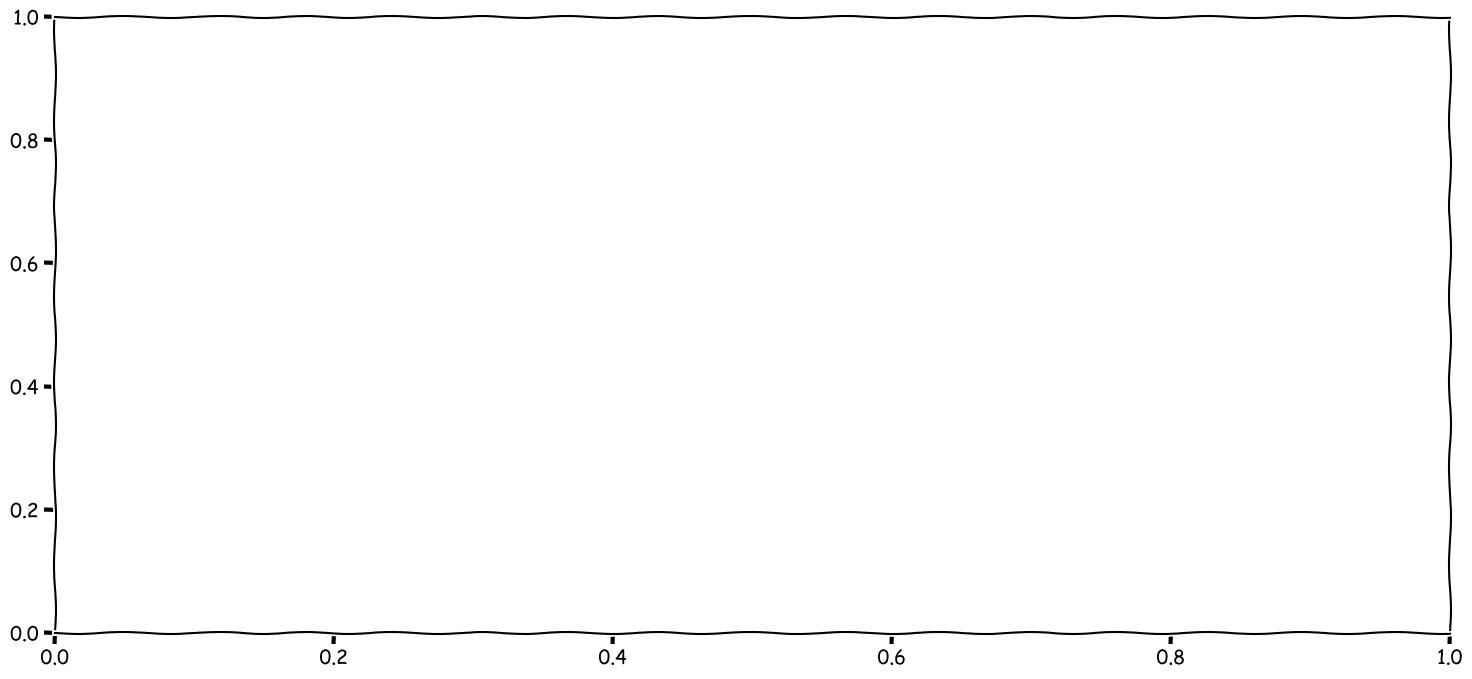

In [10]:
plt.xkcd()
fig, ax = plt.subplots(figsize=(18,8))

for dest in cheapest['Destination'].unique():
    temp = cheapest[cheapest['Destination']==dest]
    ax.plot(temp['Departure'], temp['Price'], label=dest)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('£{x:,.0f}'))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b (%a)'))
    #plt.grid(color='b', linestyle='-', linewidth=.5)
    plt.legend()

In [ ]:
#table = ff.create_table(cheapest)
#init_notebook_mode(connected=True) 
#pyo.iplot(table, filename='jupyter-table1')